# 6. XGBOOST MODEL BUILD

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import psutil  # For computational overhead tracking
import time    # For measuring execution time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

## Load Train and Test Datasets

In [2]:
# Load train and test datasets
df_train = pd.read_csv('../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/train.csv')
df_test = pd.read_csv('../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/test.csv')

# Separate features and target
X_train = df_train.drop(['binary_attack'], axis=1)  # Features
y_train = df_train['binary_attack']  # Target variable
X_test = df_test.drop(['binary_attack'], axis=1)  # Features
y_test = df_test['binary_attack']  # Target variable

# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Display dataset shapes
X_train.shape, X_val.shape, X_test.shape


((100778, 42), (25195, 42), (22544, 42))

# Feature Selection - Remove Low-Importance Features

In [3]:
# Train an initial XGBoost model to get feature importances
temp_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
temp_model.fit(X_train, y_train)

# Get feature importances
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': temp_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Drop features with importance below a threshold (e.g., 0.005)
low_importance_features = feature_importance[feature_importance['Importance'] < 0.005]['Feature'].tolist()

# Remove low-importance features
X_train = X_train.drop(columns=low_importance_features)
X_val = X_val.drop(columns=low_importance_features)
X_test = X_test.drop(columns=low_importance_features)

print(f"Removed {len(low_importance_features)} low-importance features: {low_importance_features}")


Removed 21 low-importance features: ['dst_host_diff_srv_rate', 'dst_host_srv_serror_rate', 'wrong_fragment', 'same_srv_rate', 'srv_serror_rate', 'num_root', 'logged_in', 'rerror_rate', 'srv_rerror_rate', 'num_file_creations', 'srv_diff_host_rate', 'num_failed_logins', 'urgent', 'root_shell', 'land', 'su_attempted', 'is_host_login', 'num_outbound_cmds', 'num_access_files', 'num_shells', 'is_guest_login']


# Track Computational Overhead Before Training

In [4]:
# Start measuring computational overhead
start_time = time.time()
cpu_before = psutil.cpu_percent(interval=None)
mem_before = psutil.virtual_memory().used
disk_before = psutil.disk_io_counters().write_bytes

# Apply SMOTE for Class Balancing

In [5]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train XGBoost Model with Regularization and Early Stopping

In [6]:
xgb_model = XGBClassifier(
    n_estimators=500,         # More trees for better learning
    max_depth=4,              # Lower depth to prevent overfitting
    learning_rate=0.03,       # Reduce learning rate
    subsample=0.7,            # Use 60% of training data per tree
    colsample_bytree=0.5,     # Use 60% of features per tree
    reg_lambda=10,            # Higher L2 regularization
    reg_alpha=1,              # Higher L1 regularization
    grow_policy="lossguide",  # Helps prune unnecessary deep trees
#    use_label_encoder=False,  # Suppress unnecessary warnings
    eval_metric="logloss",    # Metric for early stopping
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# Evaluate Model on Test Data

In [8]:
# Predict on test set
y_pred = xgb_model.predict(X_test)

# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n📌 **Final Model Performance on Test Set**")
print(f"✅ Accuracy:   {accuracy:.4f}")
print(f"✅ Precision:  {precision:.4f}")
print(f"✅ Recall:     {recall:.4f}")
print(f"✅ F1-score:   {f1:.4f}")



📌 **Final Model Performance on Test Set**
✅ Accuracy:   0.8680
✅ Precision:  0.7773
✅ Recall:     0.9722
✅ F1-score:   0.8639


# Track Computational Overhead After Training

In [9]:
# Capture system metrics after training
end_time = time.time()
cpu_after = psutil.cpu_percent(interval=None)
mem_after = psutil.virtual_memory().used
disk_after = psutil.disk_io_counters().write_bytes

# Compute computational overhead
execution_time = end_time - start_time
cpu_usage_change = cpu_after - cpu_before
memory_used = (mem_after - mem_before) / (1024 ** 2)  # Convert bytes to MB
disk_io_used = (disk_after - disk_before) / (1024 ** 2)  # Convert bytes to MB


# Extract Feature Importance (Gini Importance)

In [10]:
# Extract feature importance
feature_importance = xgb_model.feature_importances_

# Convert to DataFrame
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display Top Features
print("Top 11 Important Features:\n", importance_df.head(14))


Top 11 Important Features:
                         Feature  Importance
5                     dst_bytes    0.197239
4                     src_bytes    0.178459
3                          flag    0.139252
11                diff_srv_rate    0.083673
1                 protocol_type    0.051441
20                        level    0.047145
8                         count    0.046493
15  dst_host_same_src_port_rate    0.033767
13           dst_host_srv_count    0.033367
9                     srv_count    0.026698
7               num_compromised    0.026511
14       dst_host_same_srv_rate    0.025927
6                           hot    0.025436
12               dst_host_count    0.014167


# Visualizing Feature Importance

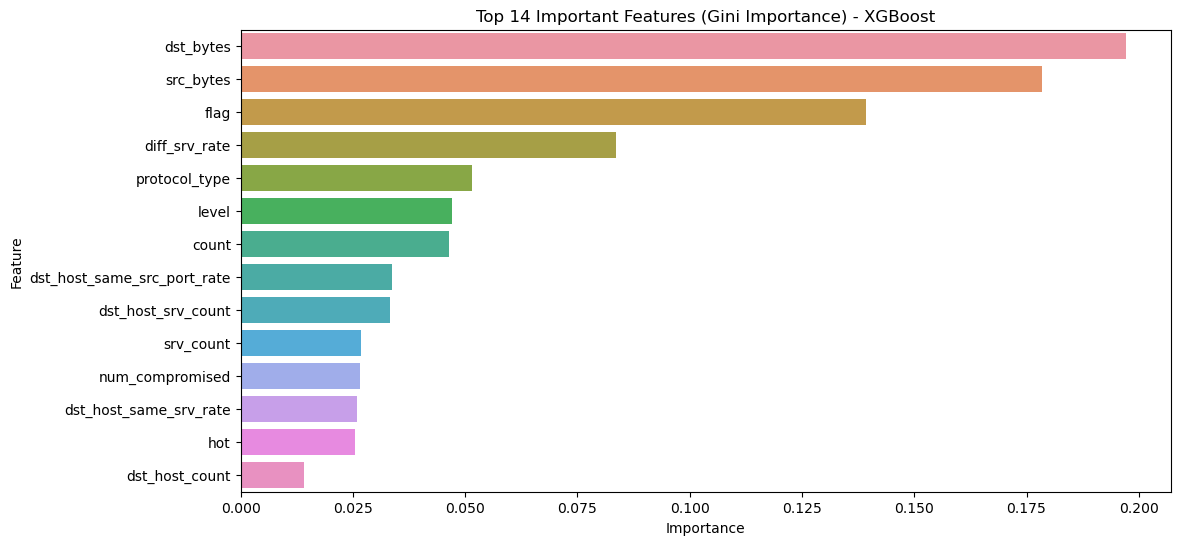

In [37]:
# Plot the top 10 important features
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df['Importance'][:14], y=importance_df['Feature'][:14])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 14 Important Features (Gini Importance) - XGBoost')
plt.show()

#  Select Top Features and Retrain the Model

In [38]:
# Select top 10 important features
top_features = importance_df['Feature'][:14].values

# Reduce dataset to selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Retrain XGBoost on Selected Features

In [39]:
# Train a new XGBoost Model using only selected features
xgb_selected_model = xgb.XGBClassifier(
    n_estimators=300,         # More trees for better learning
    max_depth=2,              # Lower depth to prevent overfitting
    learning_rate=0.02,       # Reduce learning rate
    subsample=0.7,            # Use 60% of training data per tree
    colsample_bytree=0.7,     # Use 60% of features per tree
    reg_lambda=10,            # Higher L2 regularization
    reg_alpha=1,              # Higher L1 regularization
    grow_policy="lossguide",  # Helps prune unnecessary deep trees
#     use_label_encoder=False,  # Suppress unnecessary warnings
    eval_metric="logloss",    # Metric for early stopping
    random_state=42
)

xgb_selected_model.fit(X_train_selected, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# Evaluate the Retrained Model

In [40]:
# Predict on test set
y_test_pred_selected = xgb_selected_model.predict(X_test_selected)

# Compute accuracy
test_accuracy_selected = accuracy_score(y_test, y_test_pred_selected)
test_precision_selected = precision_score(y_test, y_test_pred_selected)
test_recall_selected = recall_score(y_test, y_test_pred_selected)
test_f1_selected = f1_score(y_test, y_test_pred_selected)

print("\nTest Metrics (Using Selected Features):")
print(f"Accuracy:   {test_accuracy_selected:.2%}")
print(f"Precision:  {test_precision_selected:.2%}")
print(f"Recall:     {test_recall_selected:.2%}")
print(f"F1-score:   {test_f1_selected:.2%}")


Test Metrics (Using Selected Features):
Accuracy:   86.56%
Precision:  77.55%
Recall:     96.85%
F1-score:   86.13%


# Plot Confusion Matrix

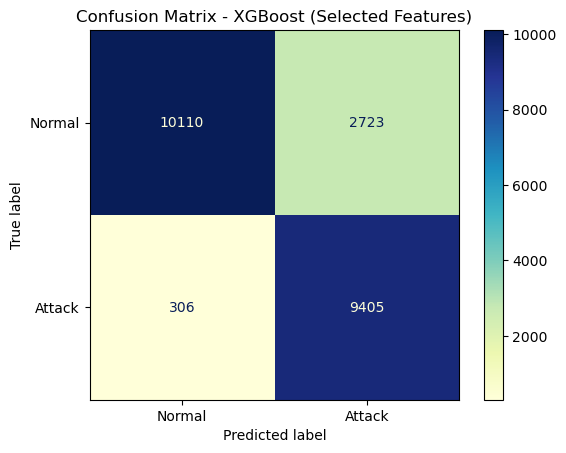

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     12833
           1       0.78      0.97      0.86      9711

    accuracy                           0.87     22544
   macro avg       0.87      0.88      0.87     22544
weighted avg       0.89      0.87      0.87     22544



In [41]:
cm = confusion_matrix(y_test, y_test_pred_selected)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='YlGnBu', values_format='d')

plt.title('Confusion Matrix - XGBoost (Selected Features)')
plt.show()

print(classification_report(y_test, y_test_pred_selected))

# Compute Inference Time per Sample

In [45]:
start_pred_time = time.time()
y_test_pred = xgb_selected_model.predict(X_test_selected)
end_pred_time = time.time()

inference_time = (end_pred_time - start_pred_time) / len(X_test)  # Time per sample


# Display Computational Overhead Report

In [46]:
print("\n🚀 **Computational Overhead Report** 🚀")
print(f"⏳ **Execution Time:** {execution_time:.4f} seconds")
print(f"🔥 **CPU Usage Change:** {cpu_usage_change:.2f}%")
print(f"💾 **Disk I/O Usage:** {disk_io_used:.2f} MB")
print(f"📊 **Peak Memory Usage:** {memory_used:.2f} MB")
print(f"⚡ **Inference Time per Sample:** {inference_time:.6f} seconds")


🚀 **Computational Overhead Report** 🚀
⏳ **Execution Time:** 36.2873 seconds
🔥 **CPU Usage Change:** 7.70%
💾 **Disk I/O Usage:** 38.39 MB
📊 **Peak Memory Usage:** -1.96 MB
⚡ **Inference Time per Sample:** 0.000001 seconds


# Scalability Test (Training Time vs. Dataset Size)

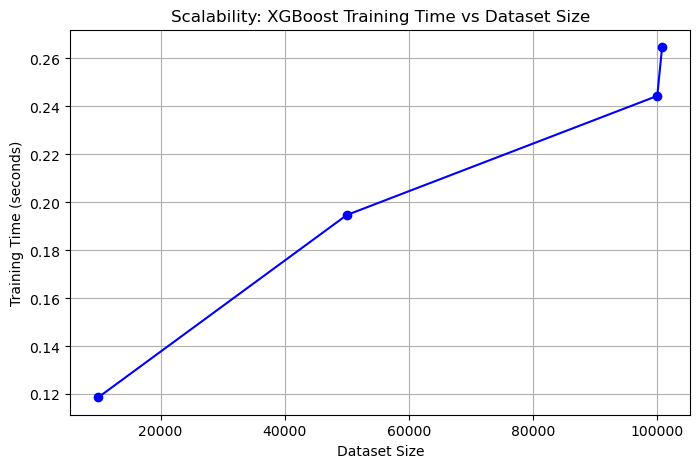

In [48]:
sizes = [10_000, 50_000, 100_000, len(X_train_selected)]
train_times = []

for size in sizes:
    X_sample, y_sample = X_train_selected[:size], y_train[:size]
    start_time = time.time()
    model = XGBClassifier(max_depth=3, n_estimators=100, random_state=42)
    model.fit(X_sample, y_sample)
    train_times.append(time.time() - start_time)

# Plot execution time
plt.figure(figsize=(8, 5))
plt.plot(sizes, train_times, marker='o', linestyle='-', color='b')
plt.xlabel("Dataset Size")
plt.ylabel("Training Time (seconds)")
plt.title("Scalability: XGBoost Training Time vs Dataset Size")
plt.grid()
plt.show()

In [50]:
# Save the trained model to a specific folder
model_folder = "../../3_Post-Modeling-Phase/Trained_ML_models/Models-NSL-KDD/"
model_filename = "NSL-KDD_XGBoost.joblib"
model_path = model_folder + model_filename

joblib.dump(xgb_selected_model, model_path)
print(f"XGBoost model saved to: {model_path}")

XGBoost model saved to: ../../3_Post-Modeling-Phase/Trained_ML_models/Models-NSL-KDD/NSL-KDD_XGBoost.joblib
